In [6]:
import holidays
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from src.data.feature_extraction import group_season, holiday, cyclical_feature


class DataPreprocessing:
    def __init__(self, train, test):
        self.train = train
        self.test = test

    @staticmethod
    def label_encode(train, test):
        categorical_col = ['item', 'corporation', 'location', 'season', 'holiday', 'corporation_weekday', 'year_season']

        for i in categorical_col:
            le = LabelEncoder()
            train[i] = le.fit_transform(train[i])
            test[i] = le.transform(test[i])

        return train, test

    @staticmethod
    def remove_outliers(train):
        print('Remove outliers')
        Q1 = train['price(원/kg)'].quantile(0.25)
        Q3 = train['price(원/kg)'].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 3 * IQR
        print(upper_bound)
        train = train[(train['price(원/kg)'] >= lower_bound) &
                      (train['price(원/kg)'] <= upper_bound)]
        return train

    @staticmethod
    def preprocessing(data):
        # time feature
        data['year'] = data['timestamp'].apply(lambda x: int(x[0:4]))
        data['month'] = data['timestamp'].apply(lambda x: int(x[5:7]))
        data['Weekday'] = pd.to_datetime(data['timestamp']).dt.weekday
        data['is_weekend'] = data['Weekday'].apply(
            lambda x: 1 if x >= 5 else 0)
        data['year'] = data['year'] - 2019
        data['season'] = group_season(data)
        data['holiday'] = holiday(data)
        # cyclical_feature(data)

        # item feature
        data['corporation_weekday'] = data['corporation'].astype(
            str) + "_" + data['Weekday'].astype(str)
        data['year_season'] = data['year'].astype(
            str) + "_" + data['season'].astype(str)

        return data

    def fit(self):
        self.train = self.preprocessing(self.train)
        self.test = self.preprocessing(self.test)

        self.train = self.remove_outliers(self.train)

        x_train = self.train.drop(
            columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
        y_train = self.train['price(원/kg)']
        x_test = self.test.drop(columns=['ID', 'timestamp'])

        x_train, x_test = self.label_encode(x_train, x_test)

        return x_train, y_train, x_test

In [12]:
train = pd.read_csv(r'./data/train.csv')
test = pd.read_csv(r'./data/test.csv')
trade = pd.read_csv(r'./data/international_trade.csv')

train['year'] = train['timestamp'].apply(lambda x : int(x[0:4]))
train['month'] = train['timestamp'].apply(lambda x : int(x[5:7]))

test['year'] = test['timestamp'].apply(lambda x : int(x[0:4]))
test['month'] = test['timestamp'].apply(lambda x : int(x[5:7]))

trade['기간'] = pd.to_datetime(trade['기간'])
trade['기간'] = trade['기간'] + pd.DateOffset(months=1)
trade['기간'] = trade['기간'].dt.to_period('M').astype(str)
trade['year'] = trade['기간'].apply(lambda x : int(x[0:4]))
trade['month'] = trade['기간'].apply(lambda x : int(x[5:7]))
trade.rename(columns={'품목명': 'item'}, inplace=True)
trade = trade.drop(columns=['기간'])

TG_train = train[train['item'] == "TG"]
CR_train = train[train['item'] == "CR"]
CB_train = train[train['item'] == "CB"]
RD_train = train[train['item'] == "RD"]
BC_train = train[train['item'] == "BC"]


TG_test = test[test['item'] == "TG"]
CR_test = test[test['item'] == "CR"]
CB_test = test[test['item'] == "CB"]
RD_test = test[test['item'] == "RD"]
BC_test = test[test['item'] == "BC"]


TG_trade = trade[trade['item'] == "감귤"]
TG_trade = TG_trade.drop(columns=['item'])

In [13]:
TG_train = pd.merge(TG_train, TG_trade, on=['year', 'month'], how='left')
TG_test = pd.merge(TG_test, TG_trade, on=['year', 'month'], how='left')



preprocessing = DataPreprocessing(TG_train, TG_test)
x, y, test = preprocessing.fit()

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1103)

RMSE: 1695.7936735444994


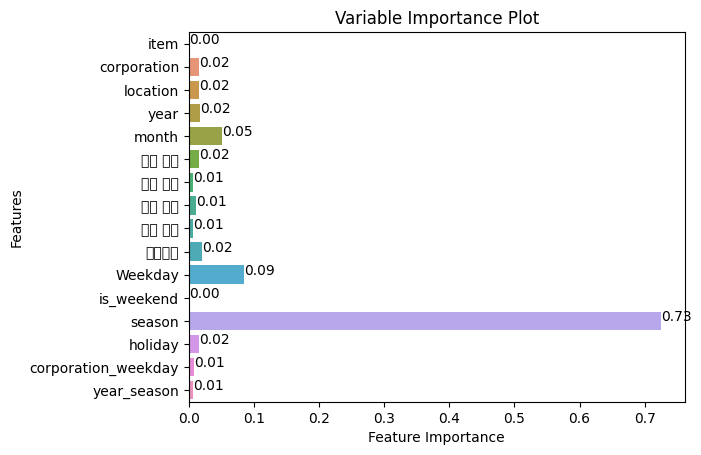

In [25]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_val)
rmse = mean_squared_error(y_val, xgb_pred, squared=False)
print(f"RMSE: {rmse}")

feature_importance = xgb.feature_importances_
for index, value in enumerate(feature_importance):
    plt.text(value, index, f'{value:.2f}')  # 소수점 둘째 자리까지 표시
sns.barplot(x=feature_importance, y=x_train.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Variable Importance Plot')
plt.show()

In [26]:
def cross_validate_models(folds, X, y, model):

    models = []
    scores = []
    for idx, (train_idx, val_idx) in enumerate(folds):
        print(f'===================================={idx+1}============================================')
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
        model.fit(x_train, y_train, early_stopping_rounds=50,
                  eval_metric='rmse', eval_set=[(x_val, y_val)], verbose=False)

        y_pred = model.predict(x_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        print(f"{idx + 1} Fold RMSE = {rmse}")
        
        scores.append(rmse)
        models.append(model)
        print(f'================================================================================\n\n')
    
    print(f"Average RMSE over {len(folds)} folds: {sum(scores)/len(folds):.4f}")
    
    return models

model = XGBRegressor(n_estimators=10000, random_state=1103)
folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=1103).split(x, y))
models = cross_validate_models(folds, x, y, model)
# predictions = sum(model.predict(x_test) for model in models) / len(folds)

====================================1============================================
1 Fold RMSE = 1646.5179721623483


====================================2============================================
2 Fold RMSE = 1617.4864181432486


====================================3============================================
3 Fold RMSE = 1531.6197159469589


====================================4============================================
4 Fold RMSE = 1568.3259791877533


====================================5============================================
5 Fold RMSE = 1600.9899329662385


====================================6============================================
6 Fold RMSE = 1501.2932886487079


====================================7============================================
7 Fold RMSE = 1619.7559057420788


====================================8============================================
8 Fold RMSE = 1643.0914354970284


====================================9===========================

In [222]:
predictions

array([3496.7437 , -242.84464, 3388.8423 , ...,  528.1222 ,  512.8326 ,
        522.0611 ], dtype=float32)

In [223]:
submission = pd.read_csv(r'data\sample_submission.csv')
submission['answer'] = np.round(predictions)
idx_list = x_test[(x_test['Weekday'] == 6)].index
submission.loc[idx_list, 'answer'] = 0
submission.to_csv('./xgb_submission.csv', index=False)